In [1]:
DATASET_NAME = "ISIC2018" # DRIVE, CVC_ClinicDB, LUNGS, ISIC2018, ISBI2012_EM
CFG_NAME = "Gauss_Unet"

In [2]:
# Import libraries

import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
import numpy as np
import time
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import callbacks
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import models as M
import losses as l

ROOT_DIR = os.path.abspath("./")
DATASET_FOLDER = "npys"
DATASET_PATH = os.path.join(ROOT_DIR, "datasets", DATASET_FOLDER)
EXPERIMENT_NAME = "{}_{}".format(DATASET_NAME, CFG_NAME)

if not os.path.exists(os.path.join(ROOT_DIR, "logs")):
    os.mkdir(os.path.join(ROOT_DIR, "logs"))

LOG_PATH = os.path.join(ROOT_DIR, "logs", EXPERIMENT_NAME)

if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
    
print(os.listdir(DATASET_PATH))

train_data = np.load("{}/{}_images.npy".format(DATASET_PATH, DATASET_NAME)) 
train_labels = np.load("{}/{}_mask.npy".format(DATASET_PATH, DATASET_NAME))
print(train_data.shape, train_labels.shape)

Using TensorFlow backend.


['ISBI2012_EM_images.npy', 'CVC-ClinicDB_images.npy', 'CVC-ClinicDB_mask.npy', 'LUNGS_mask.npy', 'LUNGS_images.npy', 'DRIVE_images.npy', 'ISBI2012_EM_mask.npy', 'ISIC2018_images.npy', 'DRIVE_mask.npy', 'ISIC2018_mask.npy']
(2594, 192, 256, 3) (2594, 192, 256, 1)


In [3]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.grid(True)
    #plt.savefig('{}/{}_loss.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.savefig('{}/{}_loss_graph.pdf'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()
    
    loss = history.history['jacard'][1:]
    val_loss = history.history['val_jacard'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation jaccard index')
    plt.ylabel('Accuracy %')
    #plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.grid(True)
    #plt.savefig('{}/{}_acc.jpg'.format(output_path, EXP_NAME), dpi=100)
    plt.savefig('{}/{}_jac_graph.pdf'.format(LOG_PATH, EXPERIMENT_NAME), dpi=100)
    plt.show()

In [4]:
# Build model
model = M.g_unet(input_size = (train_data.shape[1], train_data.shape[2], train_data.shape[-1]))
model.summary()

(3, 3, 256, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 192, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 96, 128, 32)  0           conv2d_2[0][0]                   
_____________________________________________________________________________

In [5]:
# Callbacks
weights_path = "{}/{}.h5".format(LOG_PATH, EXPERIMENT_NAME)
checkpointer = ModelCheckpoint(filepath=weights_path, verbose=0, monitor='val_jacard', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_jacard', factor=0.1, patience=10, verbose=1, min_lr=1e-8, mode='max') # new_lr = lr * factor
early_stopping = EarlyStopping(monitor='val_jacard', min_delta=0, verbose=1, patience=20, mode='max', restore_best_weights=True)
csv_logger = CSVLogger('{}/{}_training.csv'.format(LOG_PATH, EXPERIMENT_NAME))

Fold 0 train on ------->  (2075, 192, 256, 3) (519, 192, 256, 3) (2075, 192, 256, 1) (519, 192, 256, 1)
Train on 2075 samples, validate on 519 samples
Epoch 1/100000
2075/2075 [==============================] - 19s 9ms/step - loss: 0.4423 - jacard: 0.2132 - dice_coef: 0.3470 - val_loss: 0.3708 - val_jacard: 0.2857 - val_dice_coef: 0.4420
Epoch 2/100000
2075/2075 [==============================] - 15s 7ms/step - loss: 0.3845 - jacard: 0.2756 - dice_coef: 0.4294 - val_loss: 0.3550 - val_jacard: 0.2903 - val_dice_coef: 0.4473
Epoch 3/100000
2075/2075 [==============================] - 15s 7ms/step - loss: 0.3817 - jacard: 0.2887 - dice_coef: 0.4451 - val_loss: 0.3777 - val_jacard: 0.2919 - val_dice_coef: 0.4483
Epoch 4/100000
2075/2075 [==============================] - 15s 7ms/step - loss: 0.3614 - jacard: 0.3217 - dice_coef: 0.4829 - val_loss: 0.3708 - val_jacard: 0.2870 - val_dice_coef: 0.4426
Epoch 5/100000
2075/2075 [==============================] - 15s 7ms/step - loss: 0.3459 - jac

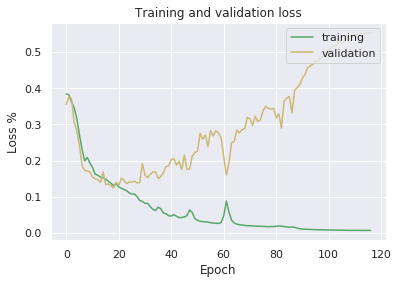

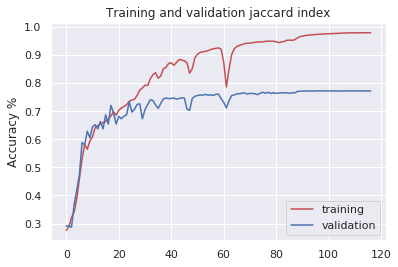

Fold 1 train on ------->  (2075, 192, 256, 3) (519, 192, 256, 3) (2075, 192, 256, 1) (519, 192, 256, 1)
Train on 2075 samples, validate on 519 samples
Epoch 1/100000
2075/2075 [==============================] - 15s 7ms/step - loss: 0.4373 - jacard: 0.2190 - dice_coef: 0.3556 - val_loss: 0.3878 - val_jacard: 0.2707 - val_dice_coef: 0.4237
Epoch 2/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.3768 - jacard: 0.2926 - dice_coef: 0.4496 - val_loss: 0.3699 - val_jacard: 0.3165 - val_dice_coef: 0.4779
Epoch 3/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.3330 - jacard: 0.3591 - dice_coef: 0.5244 - val_loss: 0.3037 - val_jacard: 0.4134 - val_dice_coef: 0.5825
Epoch 4/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.2892 - jacard: 0.4349 - dice_coef: 0.6034 - val_loss: 0.3078 - val_jacard: 0.4499 - val_dice_coef: 0.6186
Epoch 5/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.2859 - jac

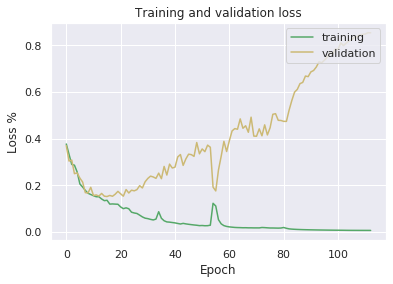

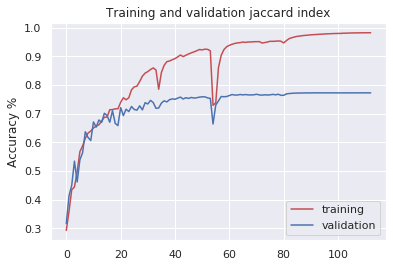

Fold 2 train on ------->  (2075, 192, 256, 3) (519, 192, 256, 3) (2075, 192, 256, 1) (519, 192, 256, 1)
Train on 2075 samples, validate on 519 samples
Epoch 1/100000
2075/2075 [==============================] - 15s 7ms/step - loss: 0.4135 - jacard: 0.2381 - dice_coef: 0.3789 - val_loss: 0.3540 - val_jacard: 0.2985 - val_dice_coef: 0.4582
Epoch 2/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.3511 - jacard: 0.3354 - dice_coef: 0.4987 - val_loss: 0.3261 - val_jacard: 0.4227 - val_dice_coef: 0.5919
Epoch 3/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.2936 - jacard: 0.4343 - dice_coef: 0.6007 - val_loss: 0.2413 - val_jacard: 0.4948 - val_dice_coef: 0.6605
Epoch 4/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.2396 - jacard: 0.5154 - dice_coef: 0.6779 - val_loss: 0.2673 - val_jacard: 0.5177 - val_dice_coef: 0.6803
Epoch 5/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.2277 - jac

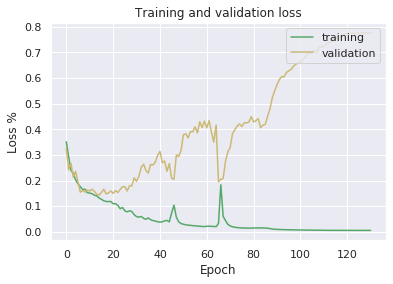

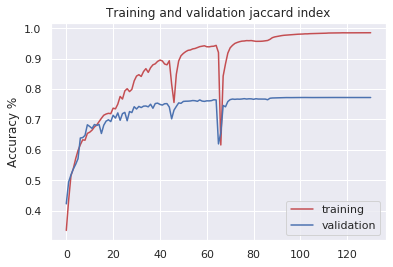

Fold 3 train on ------->  (2075, 192, 256, 3) (519, 192, 256, 3) (2075, 192, 256, 1) (519, 192, 256, 1)
Train on 2075 samples, validate on 519 samples
Epoch 1/100000
2075/2075 [==============================] - 15s 7ms/step - loss: 0.4314 - jacard: 0.2135 - dice_coef: 0.3493 - val_loss: 0.4001 - val_jacard: 0.2437 - val_dice_coef: 0.3904
Epoch 2/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.3836 - jacard: 0.2700 - dice_coef: 0.4219 - val_loss: 0.3825 - val_jacard: 0.2867 - val_dice_coef: 0.4433
Epoch 3/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.3745 - jacard: 0.2975 - dice_coef: 0.4554 - val_loss: 0.3583 - val_jacard: 0.3465 - val_dice_coef: 0.5117
Epoch 4/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.3226 - jacard: 0.3781 - dice_coef: 0.5453 - val_loss: 0.3003 - val_jacard: 0.4148 - val_dice_coef: 0.5832
Epoch 5/100000
2075/2075 [==============================] - 14s 7ms/step - loss: 0.2922 - jac

In [6]:
# Store results from multiple runs
jacs = []
dices = []
all_epochs = []
losses = []

best_jac = 0

# Calculate the starting time    
start_time = time.time()

for i in range(5):
    
    # Split the data
    #x_train, x_test, y_train, y_test = train_test_split(train_data, train_labels, shuffle=True, test_size=0.20, random_state=42)
    indices=list(range(len(train_data)))
    np.random.shuffle(indices)
    ind=int(len(indices)*0.80)
    train = indices[:ind]
    test = indices[-(len(indices)-ind):]

    x_train = train_data[train]
    x_test = train_data[test]
    y_train = train_labels[train]
    y_test = train_labels[test]

    print("Fold {} train on -------> ".format(i), x_train.shape, x_test.shape, y_train.shape, y_test.shape)
    
    # Clearing the NN.
    K.clear_session()
    model = None 
    
    # Get model
    model = M.unet(input_size = (train_data.shape[1], train_data.shape[2], train_data.shape[-1]))
    
    # Train
    batch_size = 16 #16 
    epochs = 100000
    model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_lr],
                    shuffle=True)
    
    
    # Log number of epochs to train and minimum loss
    total_epochs = len(model.history.history['loss'])
    min_loss = min(model.history.history['val_loss'])
    all_epochs.append(total_epochs)
    losses.append(min_loss)

    
    
    
    # Evaluate trained model using Jaccard and Dice metric
    yp = None
    yp = model.predict(x=x_test, batch_size=batch_size, verbose=0)
    yp = np.round(yp,0)

    jacard = 0
    dice = 0
    
    for i in range(len(y_test)):
        yp_2 = yp[i].ravel()
        y2 = y_test[i].ravel()

        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))  
        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))

    jacard /= len(y_test)
    dice /= len(y_test)

    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))
    
    jacs.append(jacard)
    dices.append(dice)
    
    #best_jac = max(jacs)
    
    if jacard > best_jac:
        
        print('***********************************************')
        print('Jacard Index improved from '+str(best_jac)+' to '+str(jacard))
        print('***********************************************')
        # Save model
        model.save(weights_path)
        
        # Save loss
        loss_history = model.history.history["val_loss"]
        loss_history = np.array(loss_history)
        np.savetxt("{}/{}_loss.txt".format(LOG_PATH, EXPERIMENT_NAME), loss_history, delimiter=",")
        
        # Save jaccard
        jacard_history = model.history.history["val_jacard"]
        jacard_history = np.array(jacard_history)
        np.savetxt("{}/{}_jacard.txt".format(LOG_PATH, EXPERIMENT_NAME), jacard_history, delimiter=",")
        
        # Save images, masks, and predicted masks
        np.save("{}/{}_inputs.npy".format(LOG_PATH, EXPERIMENT_NAME), x_test)
        np.save("{}/{}_masks.npy".format(LOG_PATH, EXPERIMENT_NAME), y_test)
        np.save("{}/{}_predicted_masks.npy".format(LOG_PATH, EXPERIMENT_NAME), yp)
        
        # Log training history
        plot_loss_accu(model.history)
        
        final_images = x_test
        final_masks = y_test
        final_preds = yp
        
        best_jac = jacard


end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))

In [7]:
jacs = [x * 100 for x in jacs]
dices = [x * 100 for x in dices]

In [8]:
jacs, dices

([77.03313901832473,
  77.16025873163457,
  78.09281542209283,
  77.73296174859816,
  77.73798602868769],
 [85.28743776572003,
  85.35458641362727,
  86.21456219492268,
  86.17464958273425,
  85.77702682752408])

In [9]:
print("Jaccard: %.4f%% (+/- %.4f%%)" % (np.mean(jacs), np.std(jacs)))
print("Dice: %.4f%% (+/- %.4f%%)" % (np.mean(dices), np.std(dices)))
print("Epochs: %.4f%% (+/- %.4f%%)" % (np.mean(all_epochs), np.std(all_epochs)))
print("Loss: %.4f%% (+/- %.4f%%)" % (np.mean(losses), np.std(losses)))

Jaccard: 77.5514% (+/- 0.3956%)
Dice: 85.7617% (+/- 0.3915%)
Epochs: 119.0000% (+/- 10.8074%)
Loss: 0.1402% (+/- 0.0092%)


In [10]:
# Store report

report = {}

report['Mean Jaccard + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(jacs), np.std(jacs)))
report['Mean Dice + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(dices), np.std(dices)))
report['Mean Epoch + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(all_epochs), np.std(all_epochs)))
report['Mean Loss + Std = '] = ("%.4f%% +/- %.4f%%" % (np.mean(losses), np.std(losses)))

with open("{}/{}_REPORT.txt".format(LOG_PATH, EXPERIMENT_NAME), 'w') as f:
    for k,v in report.items():
        f.write(str(k))
        #f.write("--->")
        f.write(str(v))
        
        # new line
        f.write("\n")

f.close()

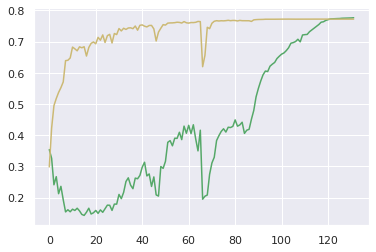

In [11]:
l = loss_history
j = jacard_history
epochs = range(len(j))
plt.plot(epochs, l, 'g')
plt.plot(epochs, j, 'y')

In [12]:
x_test = final_images
y_test = final_masks
yp = final_preds

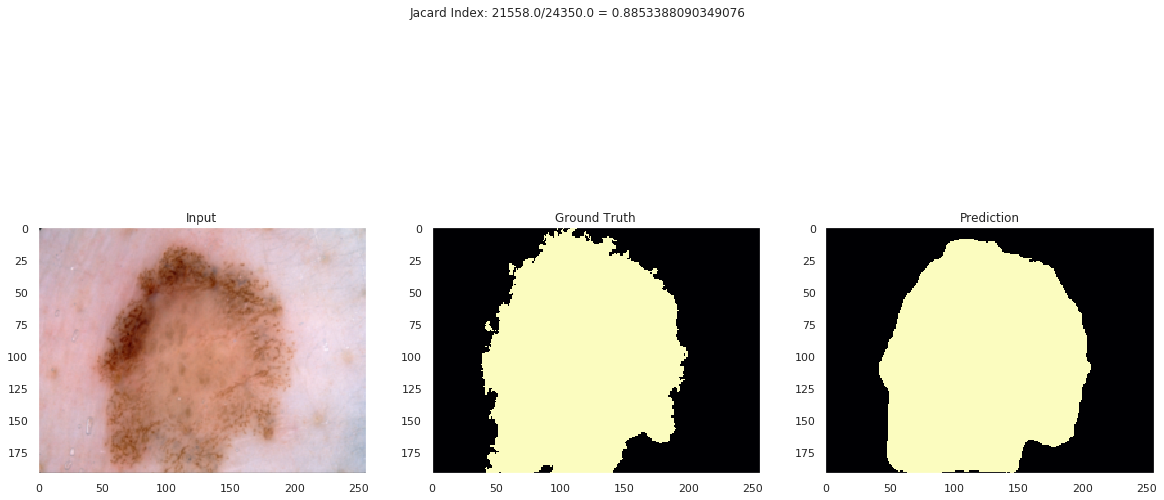

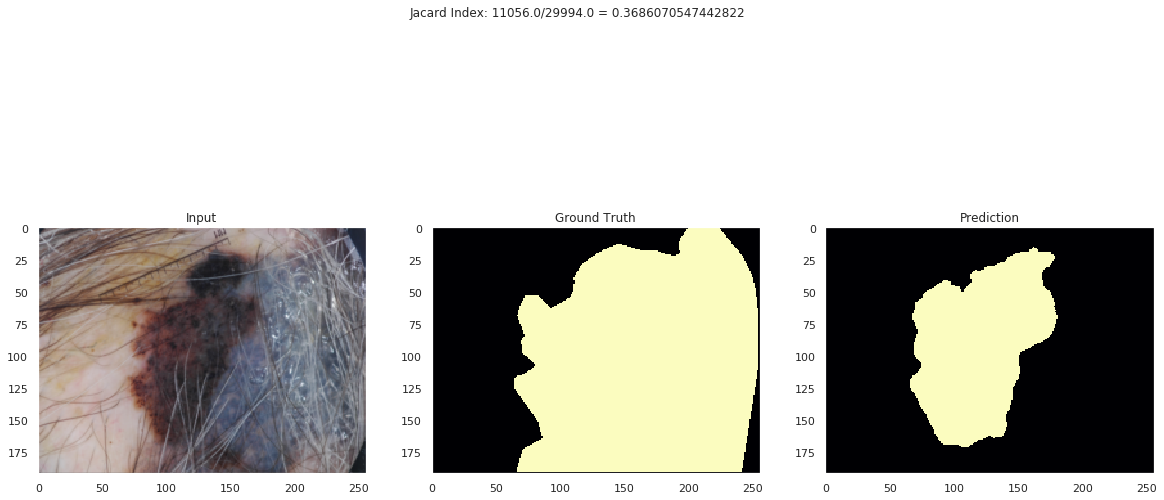

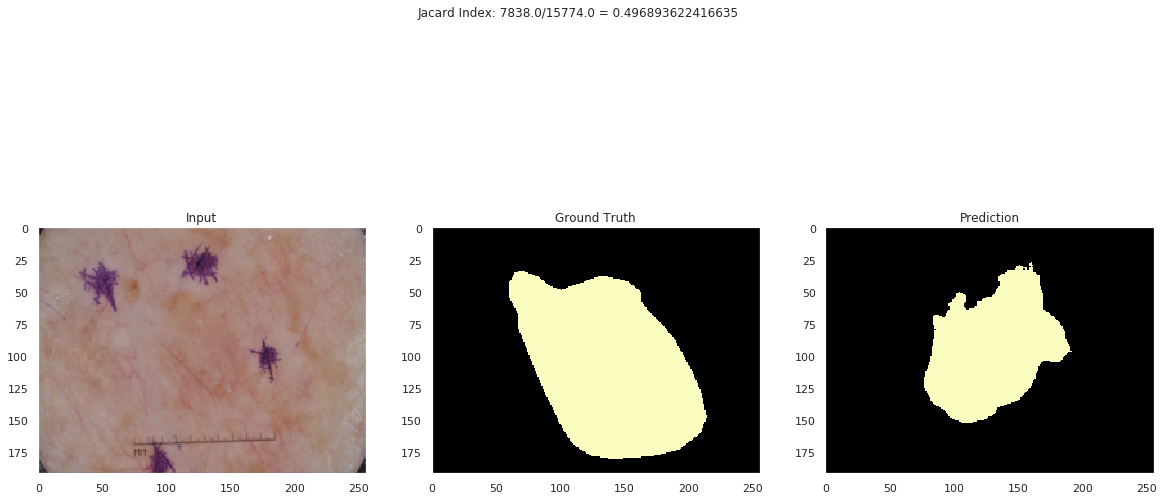

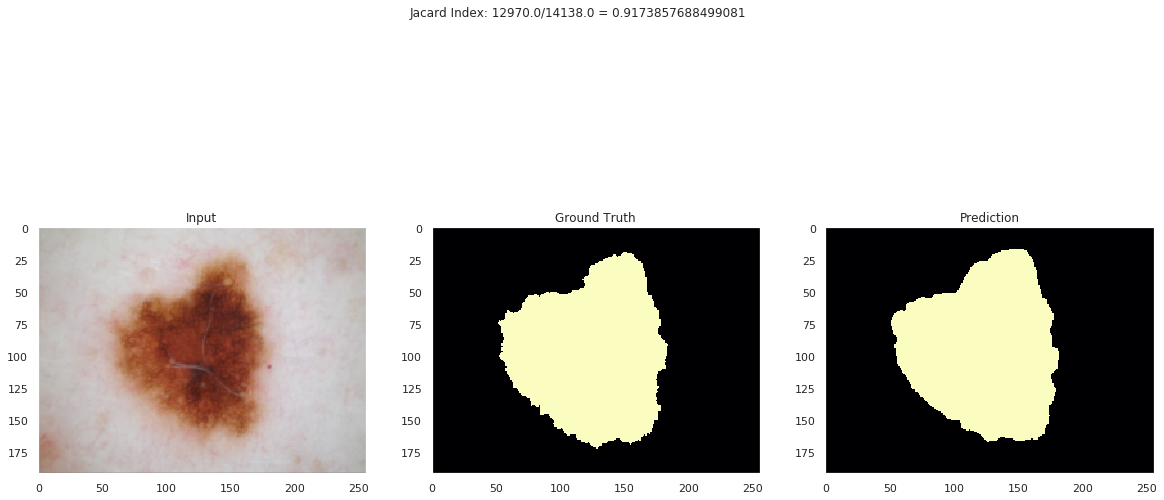

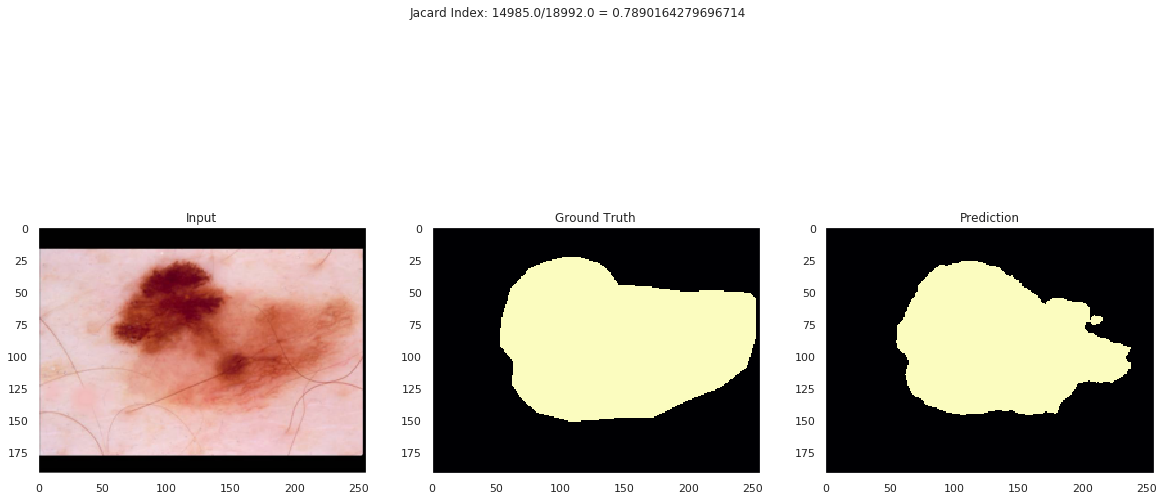

In [13]:
try:
    os.makedirs('{}/results/'.format(LOG_PATH, EXPERIMENT_NAME))
except:
    pass 

for i in range(5):
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    if len(x_test[i].shape) >= 2:
        plt.grid(False)
        plt.imshow(x_test[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.imshow(x_test[i]) # 3-channel
        
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.grid(False)
    plt.imshow(y_test[i].reshape(y_test[i].shape[0],y_test[i].shape[1]), cmap='magma')
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.grid(False)
    plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]), cmap='magma')
    plt.title('Prediction')
    
    # Calc jaccard index of predictions
    intersection = yp[i].ravel() * y_test[i].ravel()
    union = yp[i].ravel() + y_test[i].ravel() - intersection
    jacard = (np.sum(intersection)/np.sum(union))  
    
    plt.suptitle('Jacard Index: '+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +' = '+str(jacard))
    plt.savefig('{}/results/'.format(LOG_PATH, EXPERIMENT_NAME)+str(i)+'.png',format='png')
    plt.show()
    plt.close()